In [1]:
from keras import (
    layers,
    models,
    optimizers,
    utils,
    callbacks,
    metrics,
    losses,
    activations,
)
import keras
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt

W0000 00:00:1764783404.216659 1253876 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764783404.216676 1253876 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764783404.216678 1253876 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764783404.216679 1253876 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
2025-12-03 20:36:44.219489: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other o

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 64
DATASET_REPETITIONS = 5

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 15

STUDENT_ID = "1032259319"
IMG_TYPE = int(STUDENT_ID[-1])

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
full_train_data = np.append(x_train, x_test, axis=0)
full_train_labels = np.append(y_train, y_test)

train_data = full_train_data[full_train_labels == IMG_TYPE]
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)

I0000 00:00:1764783406.783295 1253876 gpu_device.cc:2395] Ignoring visible gpu device (device: 1, name: AMD Ryzen 7 7800X3D 8-Core Processor, pci bus id: 0000:11:00.0) with AMDGPU version : gfx1036. The supported AMDGPU versions are gfx900, gfx906, gfx908, gfx90a, gfx942, gfx950, gfx1030, gfx1100, gfx1101, gfx1103, gfx1150, gfx1151, gfx1200, gfx1201.
I0000 00:00:1764783406.856140 1253876 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15468 MB memory:  -> device: 0, name: AMD Radeon RX 9070 XT, pci bus id: 0000:03:00.0


In [4]:
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train = train_dataset.map(lambda x: preprocess(x))     
train = train.repeat(DATASET_REPETITIONS)          
train = train.batch(BATCH_SIZE, drop_remainder=True) # 4)

In [5]:
def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + \
        diffusion_times * (end_angle - start_angle)

    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

In [6]:
@keras.saving.register_keras_serializable()
def sinusoidal_embedding(x):
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(1.0),
            tf.math.log(1000.0),
            NOISE_EMBEDDING_SIZE // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds*x), tf.cos(angular_speeds*x)], axis=3
    )
    return embeddings

In [7]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", 
            activation=activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

In [8]:
def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [9]:
noisy_images = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = layers.Conv2D(32, kernel_size=1)(noisy_images)

noise_variances = layers.Input(shape=(1, 1, 1))
noise_embedding = layers.Lambda(
    sinusoidal_embedding,
    output_shape=(1, 1, NOISE_EMBEDDING_SIZE),
)(noise_variances)
noise_embedding = layers.UpSampling2D(
    size=IMAGE_SIZE, interpolation="nearest")(noise_embedding)

x = layers.Concatenate()([x, noise_embedding])

skips = []

x = DownBlock(32, block_depth=2)([x, skips])
x = DownBlock(64, block_depth=2)([x, skips])
x = DownBlock(96, block_depth=2)([x, skips])

x = ResidualBlock(128)(x)
x = ResidualBlock(128)(x)

x = UpBlock(96, block_depth=2)([x, skips])
x = UpBlock(64, block_depth=2)([x, skips])
x = UpBlock(32, block_depth=2)([x, skips])

x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

unet = models.Model([noisy_images, noise_variances], x, name="unet")

In [10]:
class DiffusionModel(models.Model):
    def __init__(self):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = unet
        self.ema_network = models.clone_model(self.network)
        self.diffusion_schedule = offset_cosine_diffusion_schedule

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker = metrics.Mean(name="n_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker]

    def denormalize(self, images):
        images = self.normalizer.mean + \
            images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def denoise(
        self, noisy_images, noise_rates, signal_rates, training
    ):
        if training:
            network = self.network
        else:
            network = self.ema_network
        pred_noises = network(
            [noisy_images, noise_rates**2], training=training
        )
        pred_images = (noisy_images - noise_rates * pred_noises) \
            / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise
        for step in range(diffusion_steps):
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - \
                step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(
                diffusion_times
            )
            pred_noises, pred_images = self.denoise(
                current_images, noise_rates, 
                signal_rates, training=False
            )
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = \
                self.diffusion_schedule(
                    next_diffusion_times
            )
            current_images = (
                next_signal_rates * pred_images + \
                next_noise_rates * pred_noises
            )
        return pred_images

    def generate(self, num_images, diffusion_steps, initial_noise=None):
        if initial_noise is None:
            initial_noise = tf.random.normal(
                shape=(num_images, IMAGE_SIZE, IMAGE_SIZE, 3)
            )
        #print(initial_noise)
        generated_images = self.reverse_diffusion(
            initial_noise, diffusion_steps
        )
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(
            shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
        )

        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(
            diffusion_times
        )

        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images 
            # to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # training

        gradients = tape.gradient(
            noise_loss, self.network.trainable_weights
        )
        self.optimizer.apply_gradients(
            zip(gradients, self.network.trainable_weights)
        )

        self.noise_loss_tracker.update_state(noise_loss)

        for weight, ema_weight in zip(
            self.network.weights, self.ema_network.weights
        ):
            ema_weight.assign(EMA * ema_weight + (1 - EMA) * weight)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(
            shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
        )
        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(
            diffusion_times
        )
        noisy_images = signal_rates * images + noise_rates * noises
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )
        noise_loss = self.loss(noises, pred_noises)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

In [11]:
ddm = DiffusionModel()
ddm.normalizer.adapt(train)

2025-12-03 20:36:48.309335: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
import os
for path in ["./checkpoints","./logs","./models","./output"]:
    os.makedirs(path, exist_ok=True)

In [14]:
ddm.compile(
    optimizer=optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    ),
    loss=losses.mean_absolute_error,
)

In [15]:
ddm.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))

In [16]:
ddm.summary()

Model: "diffusion_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (64, 32, 32, 3)        │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ unet (Functional)               │ (None, 32, 32, 3)      │     1,953,507 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ unet (Functional)               │ (None, 32, 32, 3)      │     1,953,507 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,907,021 (14.90 MB)

 Trainable params: 3,901,254 (14.88 MB)

 Non-trainable params: 5,767 (22.53 KB)

In [17]:
def display(images, cols=10, save_to=None):
    n = len(images)
    if n == 0:
        return
    rows = math.ceil(n / cols)
    f, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    axes = axes.flat
    for i in range(n):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    for i in range(n, len(axes)):
        axes[i].set_visible(False)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")
    plt.show()

Epoch 1/15


I0000 00:00:1764783436.590378 1253958 service.cc:152] XLA service 0x7fb4740217d0 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764783436.590390 1253958 service.cc:160]   StreamExecutor device (0): AMD Radeon RX 9070 XT, AMDGPU ISA version: gfx1201
2025-12-03 20:37:16.726230: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-03 20:37:16.956131: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:62] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
I0000 00:00:1764783441.309994 1253958 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - n_loss: 0.3104
Saved to ./output/diff/generated_img_000.png


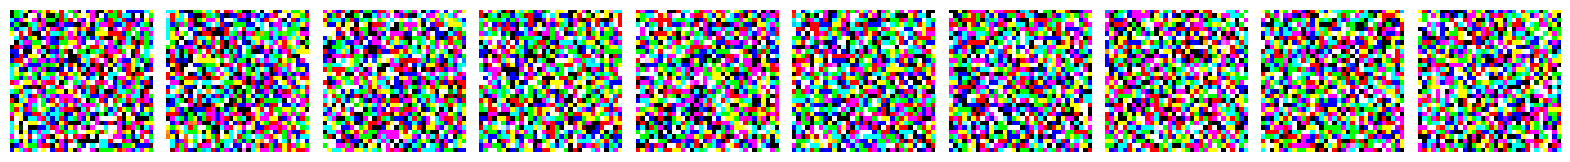

468/468 ━━━━━━━━━━━━━━━━━━━━ 80s 151ms/step - n_loss: 0.2322
Epoch 2/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - n_loss: 0.1899
Saved to ./output/diff/generated_img_001.png


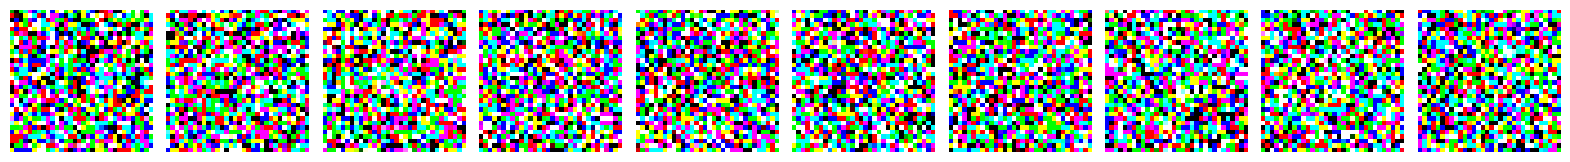

468/468 ━━━━━━━━━━━━━━━━━━━━ 72s 154ms/step - n_loss: 0.1873
Epoch 3/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - n_loss: 0.1830
Saved to ./output/diff/generated_img_002.png


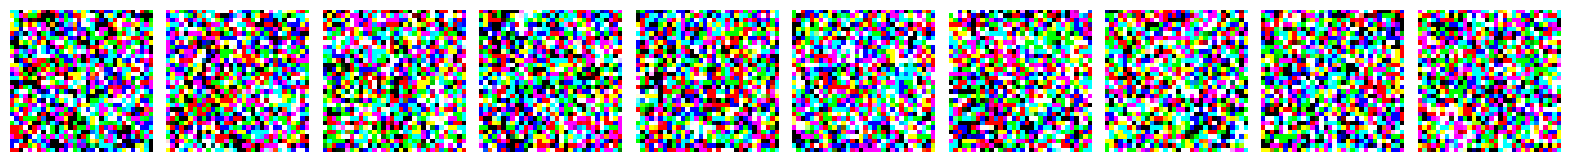

468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - n_loss: 0.1824
Epoch 4/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - n_loss: 0.1797
Saved to ./output/diff/generated_img_003.png


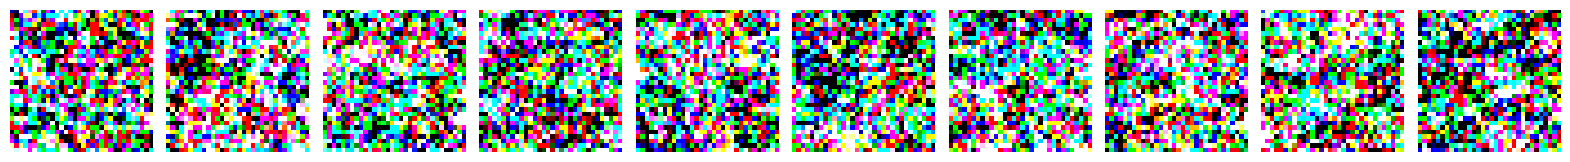

468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - n_loss: 0.1791
Epoch 5/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - n_loss: 0.1769
Saved to ./output/diff/generated_img_004.png


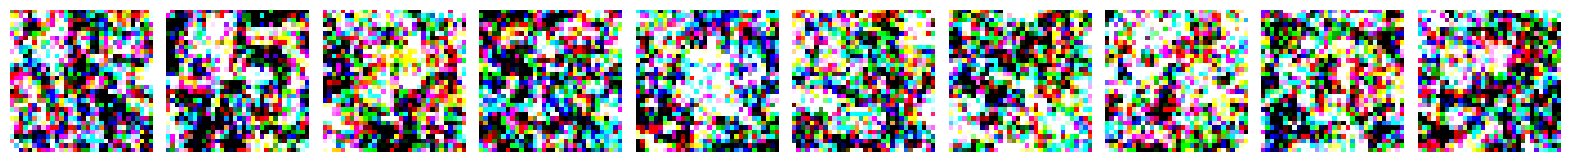

468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - n_loss: 0.1769
Epoch 6/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - n_loss: 0.1741
Saved to ./output/diff/generated_img_005.png


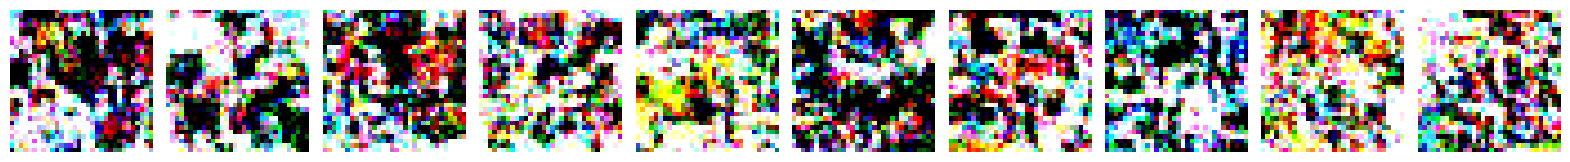

468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - n_loss: 0.1739
Epoch 7/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - n_loss: 0.1741
Saved to ./output/diff/generated_img_006.png


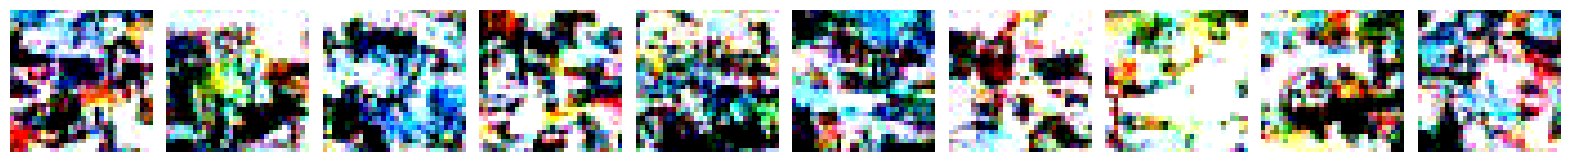

468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - n_loss: 0.1740
Epoch 8/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - n_loss: 0.1735
Saved to ./output/diff/generated_img_007.png


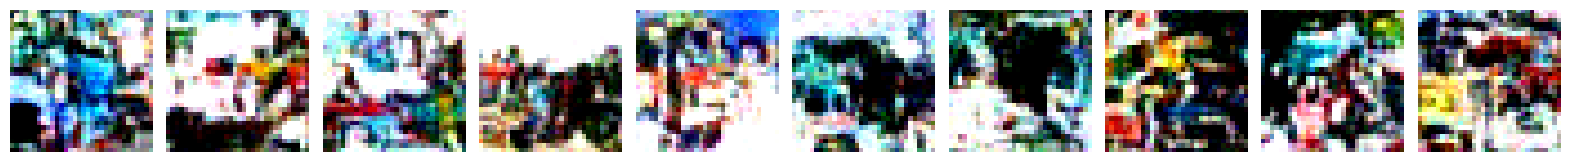

468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - n_loss: 0.1732
Epoch 9/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - n_loss: 0.1726
Saved to ./output/diff/generated_img_008.png


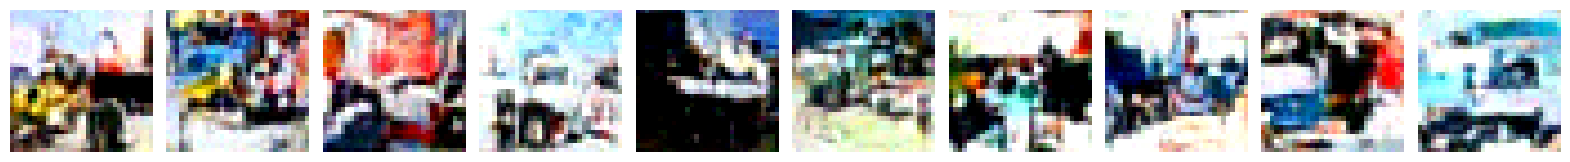

468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - n_loss: 0.1724
Epoch 10/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - n_loss: 0.1710
Saved to ./output/diff/generated_img_010.png


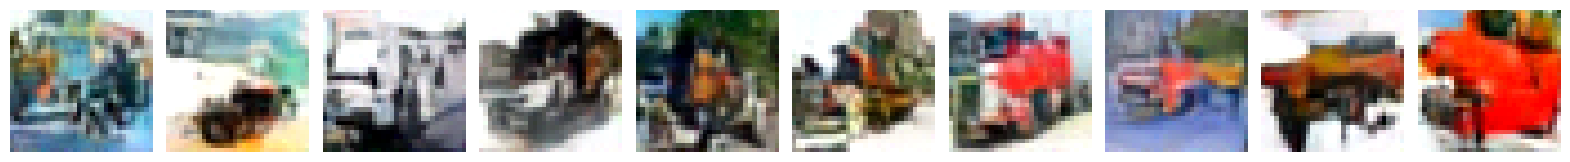

468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - n_loss: 0.1706
Epoch 12/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - n_loss: 0.1695
Saved to ./output/diff/generated_img_011.png


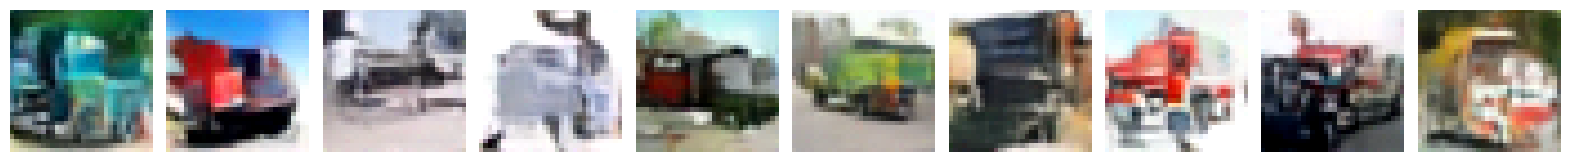

468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - n_loss: 0.1699
Epoch 13/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - n_loss: 0.1695
Saved to ./output/diff/generated_img_012.png


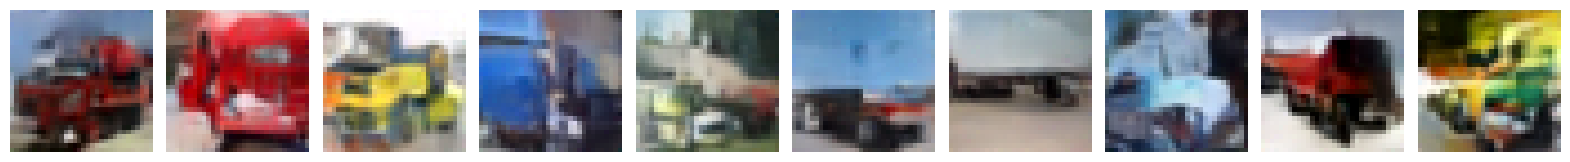

468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - n_loss: 0.1696
Epoch 14/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - n_loss: 0.1698
Saved to ./output/diff/generated_img_013.png


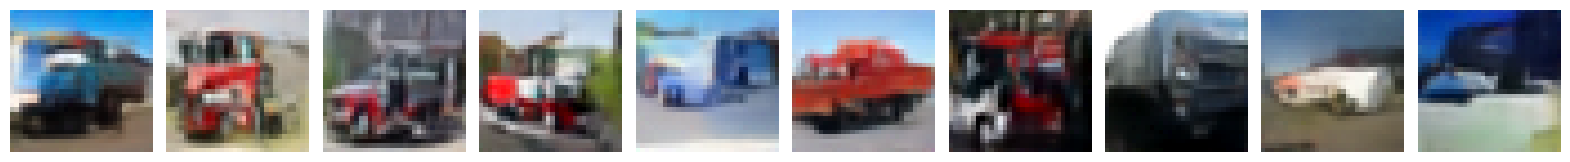

468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - n_loss: 0.1693
Epoch 15/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - n_loss: 0.1681
Saved to ./output/diff/generated_img_014.png


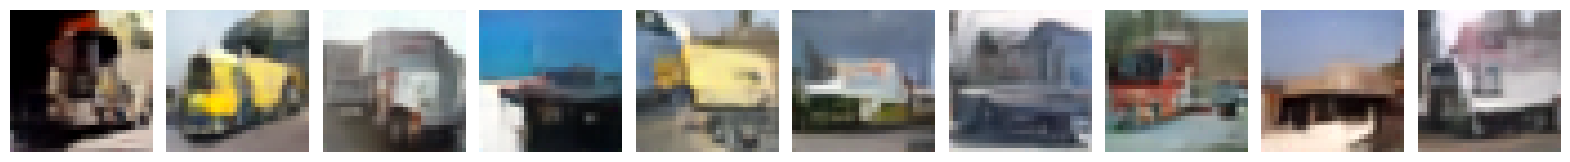

468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - n_loss: 0.1683


In [19]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoints/diff/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generate(
            num_images=self.num_img,
            diffusion_steps=PLOT_DIFFUSION_STEPS,
        ).numpy()
        display(
            generated_images,
            save_to="./output/diff/generated_img_%03d.png" % (epoch),
        )


image_generator_callback = ImageGenerator(num_img=10)

ddm.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)
    

Steps= 1


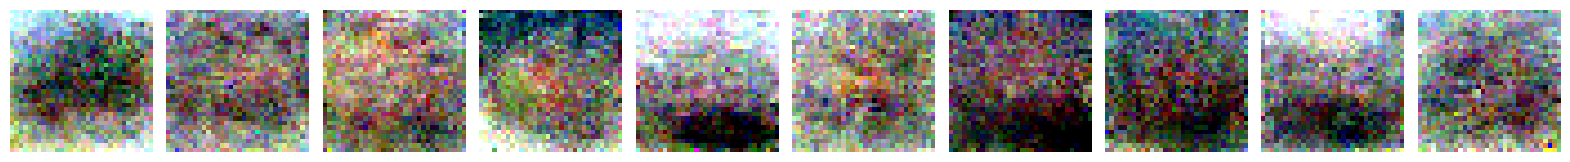

Steps= 2


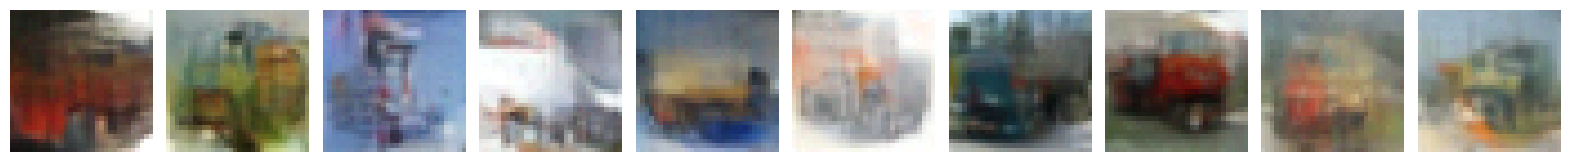

Steps= 3


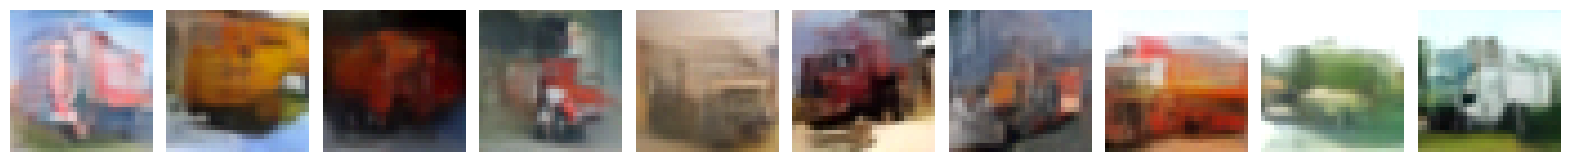

Steps= 4


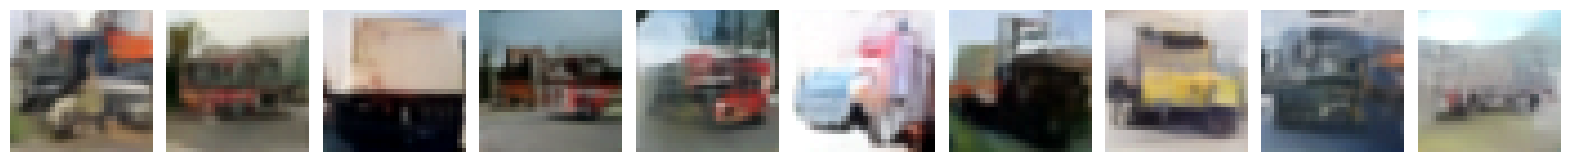

Steps= 5


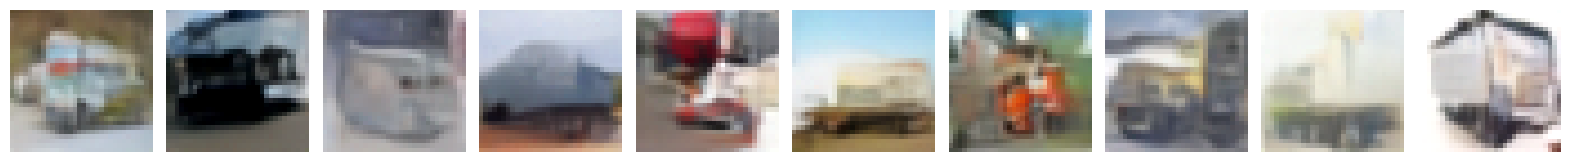

Steps= 10


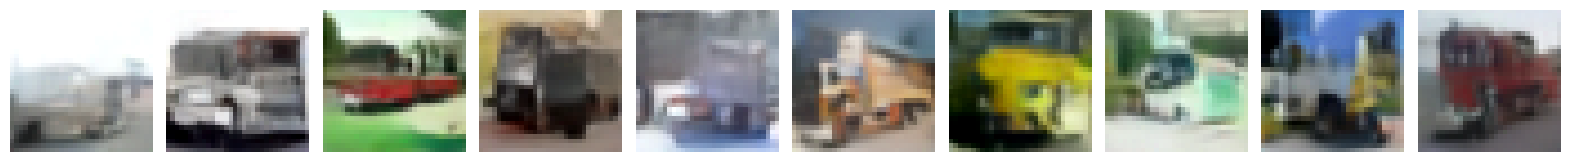

Steps= 15


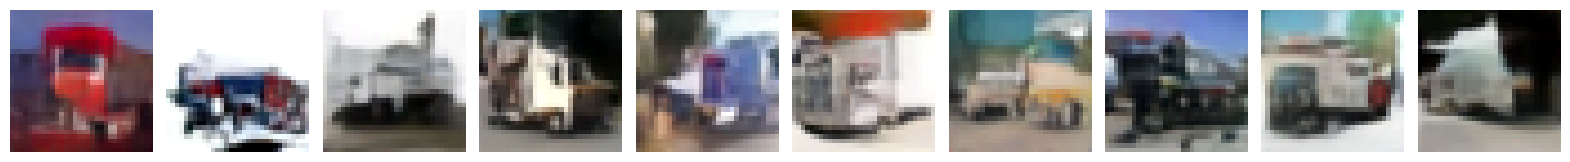

Steps= 20


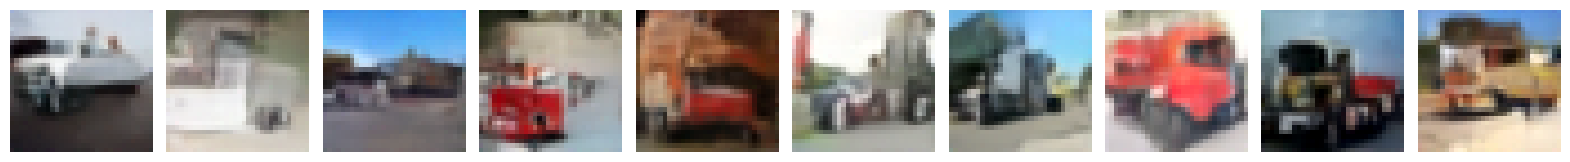

Steps= 30


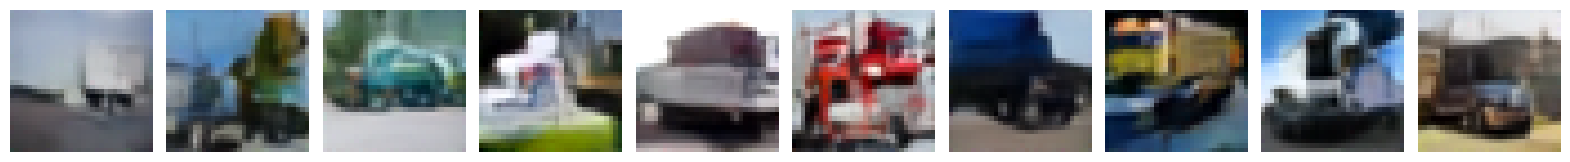

Steps= 40


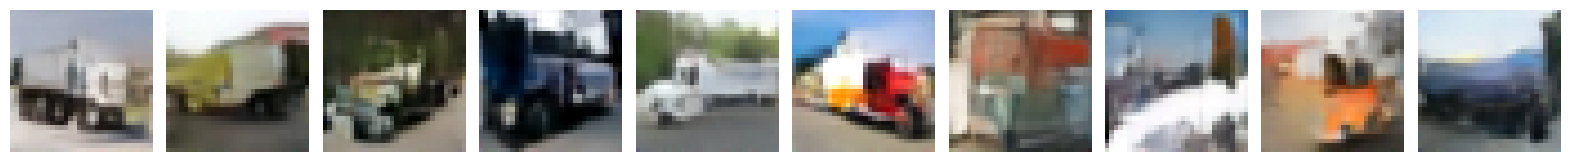

Steps= 50


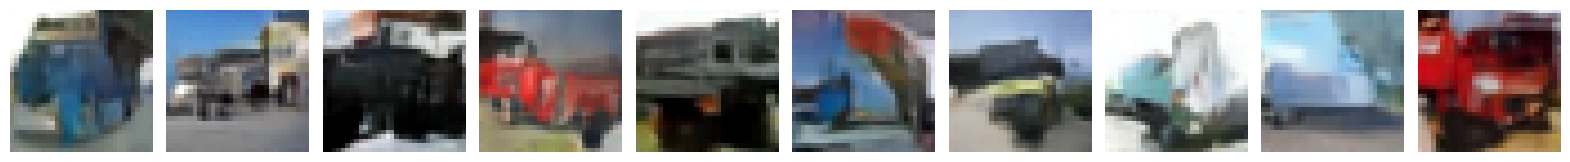

In [20]:
for steps in [1,2,3,4,5,10,15,20,30,40,50]:
    generated_images = ddm.generate(num_images=10, diffusion_steps=steps).numpy()
    print("Steps=", steps)
    display(generated_images)

(fixed noise) Steps= 1


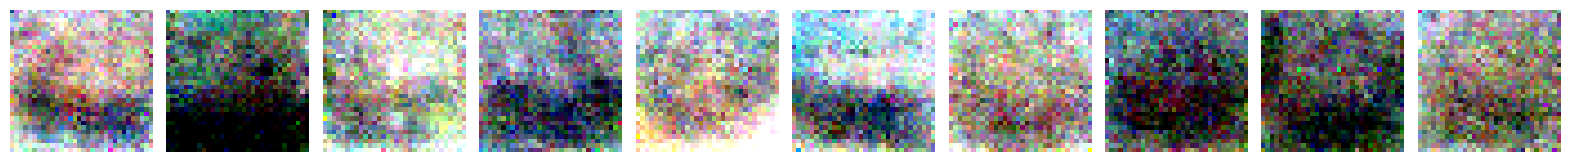

(fixed noise) Steps= 2


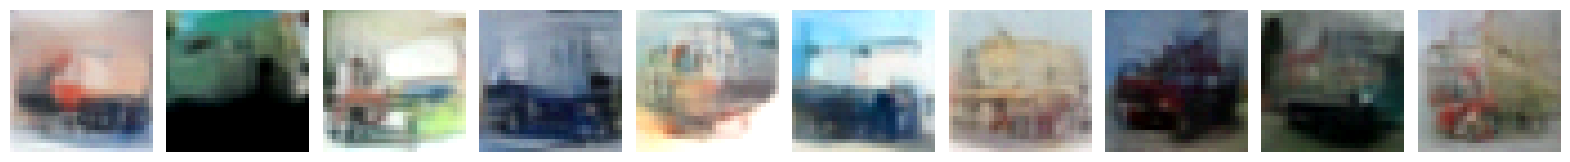

(fixed noise) Steps= 3


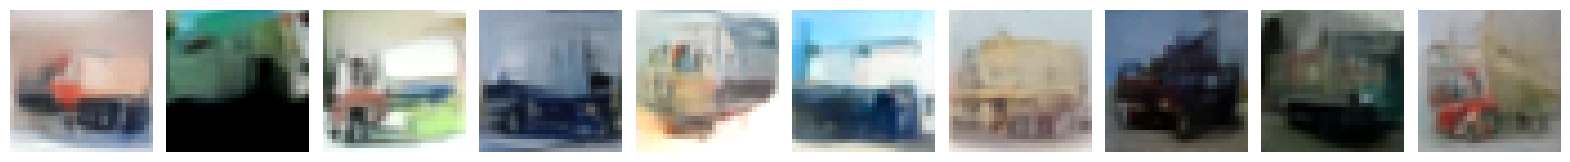

(fixed noise) Steps= 4


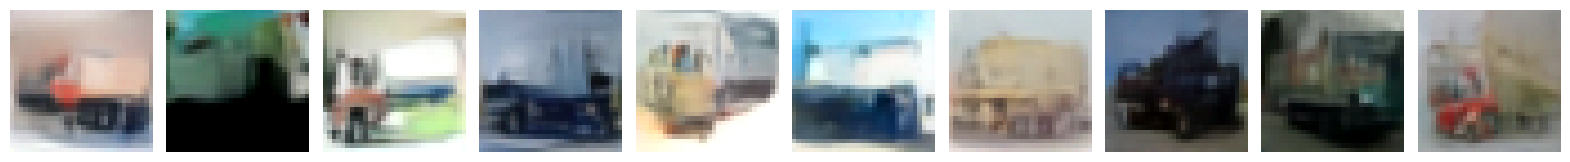

(fixed noise) Steps= 5


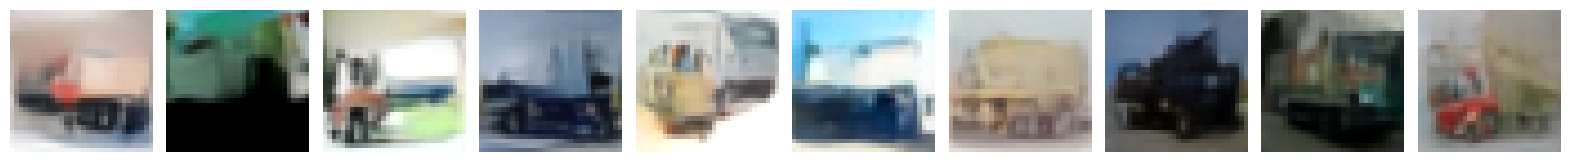

(fixed noise) Steps= 10


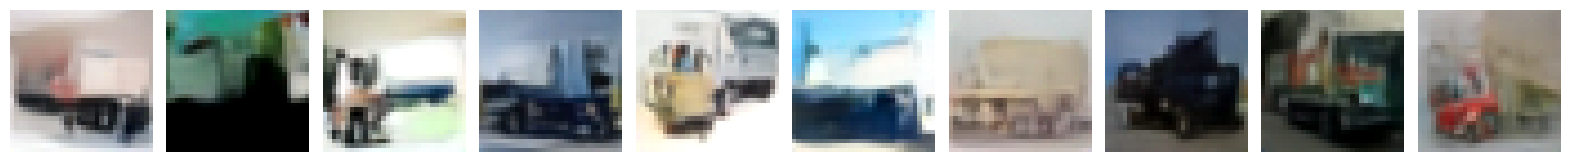

(fixed noise) Steps= 15


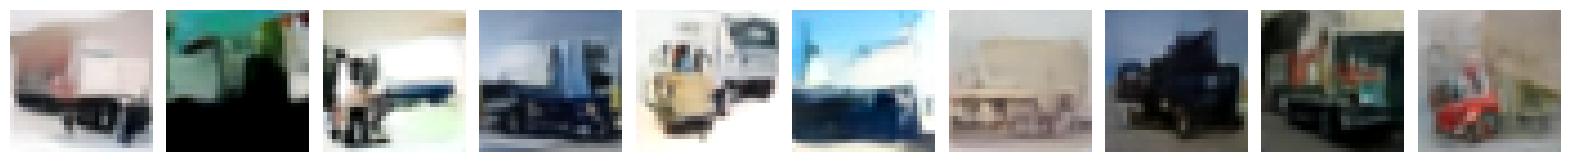

(fixed noise) Steps= 20


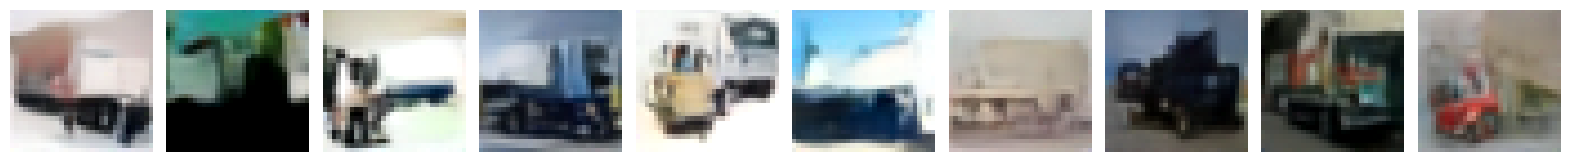

(fixed noise) Steps= 30


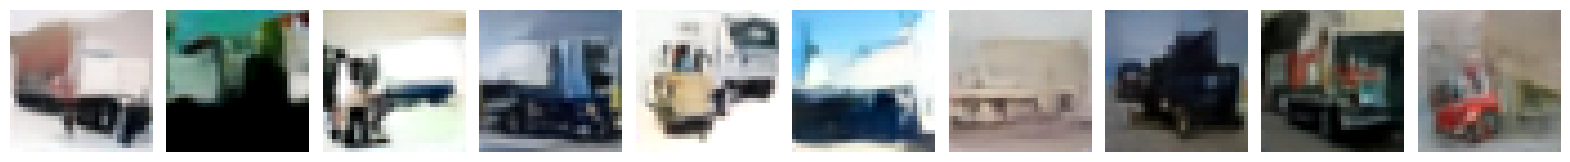

(fixed noise) Steps= 40


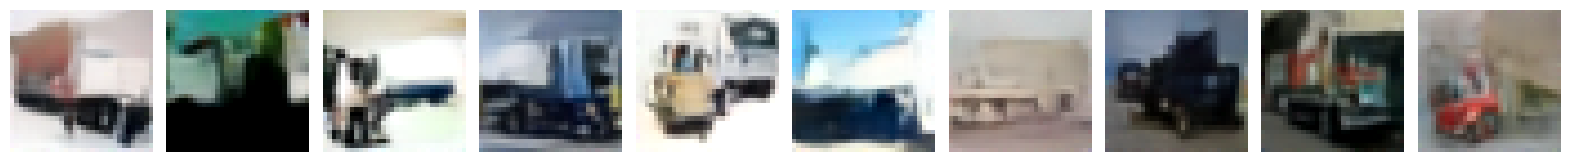

(fixed noise) Steps= 50


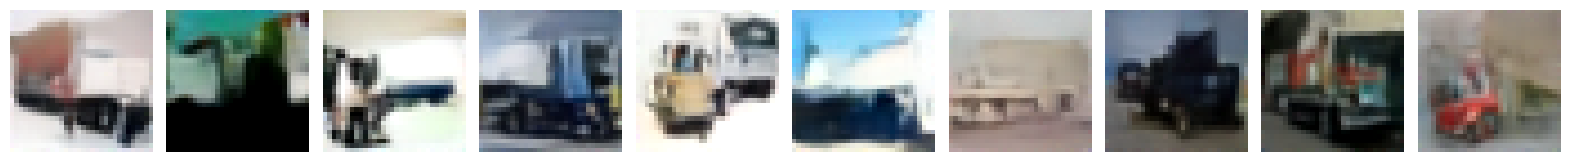

In [23]:
fixed_noise = tf.random.normal([10, IMAGE_SIZE, IMAGE_SIZE, 3])
for steps in [1,2,3,4,5,10,15,20,30,40,50]:
    generated_images = ddm.generate(num_images=10, diffusion_steps=steps, initial_noise=fixed_noise).numpy()
    print("(fixed noise) Steps=", steps)
    display(generated_images)

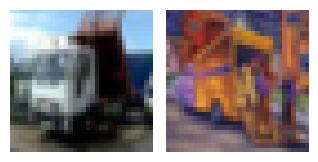

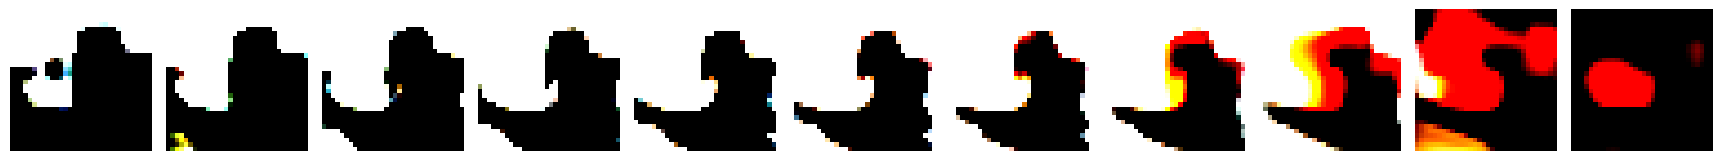

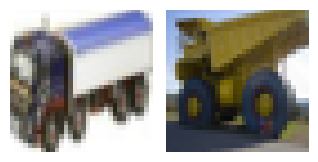

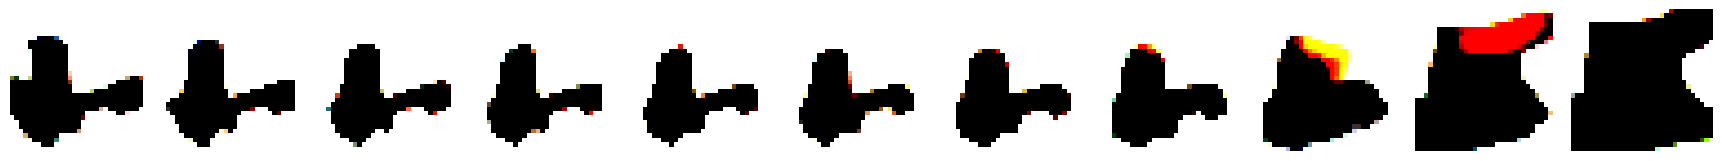

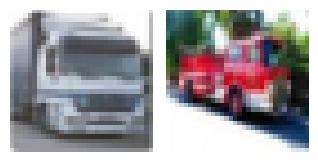

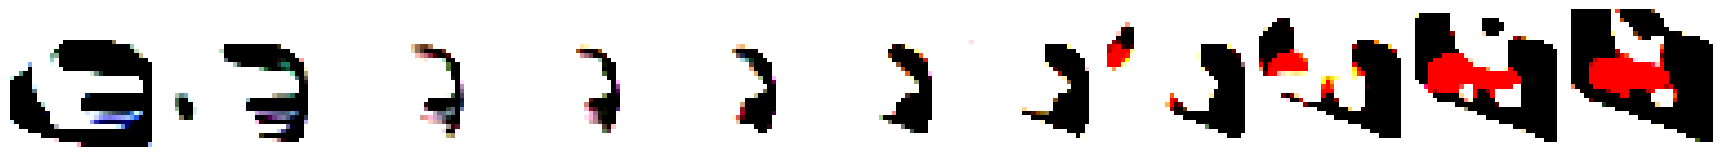

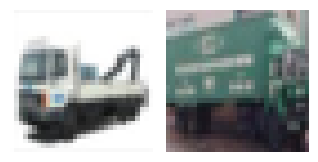

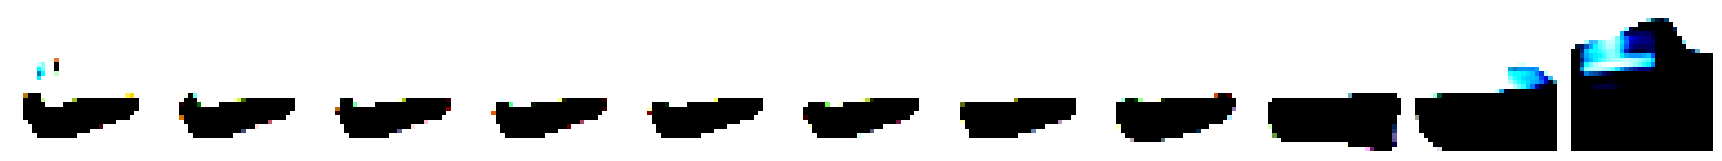

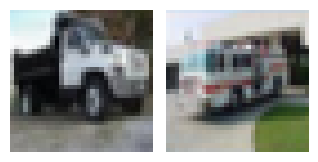

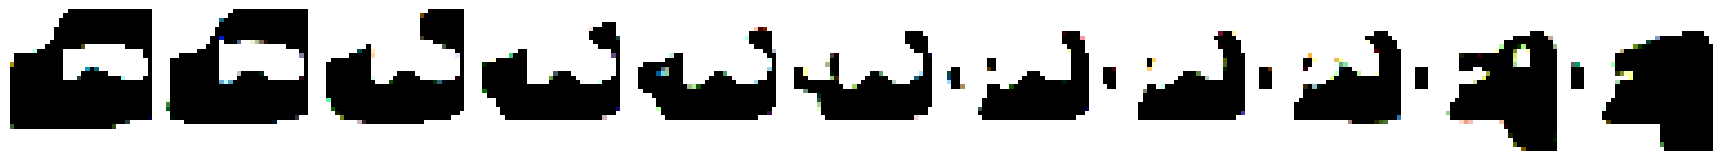

In [24]:
tf.random.set_seed(420)

def spherical_interpolation(a, b, t):
    return np.sin(t * math.pi / 2) * a + np.cos(t * math.pi / 2) * b

for i in range(5):
    row_idx = np.random.choice(train_data.shape[0])
    old_a = train_data[row_idx]
    a = preprocess(old_a)
    row_idx = np.random.choice(train_data.shape[0])
    old_b = train_data[row_idx]
    b = preprocess(old_b)
    display([a,b])
    initial_noise = tf.convert_to_tensor(
        [spherical_interpolation(b, a, t) for t in np.arange(0, 1.1, 0.1)]
    )
    initial_noise = ddm.normalizer(initial_noise)
    generated_images = ddm.generate(
        num_images=10, diffusion_steps=5, initial_noise=initial_noise
    ).numpy()
    display(generated_images, cols=13)
    print()
    print()